# REFERENCE SOLUTION: TensorFlow MNIST Lift and Shift Exercise

For this exercise notebook, you should be able to use the `Python 3 (TensorFlow 1.15 Python 3.7 CPU Optimized)` kernel on SageMaker Studio, or `conda_tensorflow_p36` on classic SageMaker Notebook Instances.

---

## Introduction

Your new colleague in the data science team (who isn't very familiar with SageMaker) has written a nice notebook to tackle an image classification problem with Keras: [Local Notebook.ipynb](Local%20Notebook.ipynb).

It works OK with the simple MNIST data set they were working on before, but now they'd like to take advantage of some of the features of SageMaker to tackle bigger and harder challenges.

**Can you help refactor the Local Notebook code, to show them how to use SageMaker effectively?**


## Getting Started

First, check you can **run the [Local Notebook.ipynb](Local%20Notebook.ipynb) notebook through** - reviewing what steps it takes.

**This notebook** sets out a structure you can use to migrate code into, and lists out some of the changes you'll need to make at a high level. You can either work directly in here, or duplicate this notebook so you still have an unchanged copy of the original.

Try to work through the sections first with an MVP goal in mind (fitting the model to data in S3 via a SageMaker Training Job, and deploying/using the model through a SageMaker Endpoint). At the end, there are extension exercises to bring in more advanced functionality.


## Dependencies

Listing all our imports at the start helps to keep the requirements to run any script/file transparent up-front, and is specified by nearly every style guide including Python's official [PEP 8](https://www.python.org/dev/peps/pep-0008/#imports)


In [2]:
!pip install ipywidgets matplotlib

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# Python Built-Ins:
import glob
import os

# External Dependencies:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np

# Local Dependencies:
from util.nb import upload_in_background

import sagemaker
from sagemaker.tensorflow import TensorFlow as TensorFlowEstimator


In [4]:
# 1. Setup the SageMaker role
role = sagemaker.get_execution_role()
# 2. Setup the SageMaker session
sess = sagemaker.Session()
# 3. Setup the SageMaker default bucket
bucket_name = sess.default_bucket()  # We'll just use the default bucket as the other examples did


## Prepare the Data and Upload to Amazon S3

The primary data source for a SageMaker training job is (nearly) always S3 - so we should upload our training and test data there.

For this exercise, we prepared a few lines of code below to help you upload the images to Amazon S3 using the [aws s3 sync](https://docs.aws.amazon.com/cli/latest/reference/s3/sync.html) CLI command.

But first, let's download the image data from the Repository of Open Data on AWS and sample a subset like we did in the [Local Notebook.ipynb](Local%20Notebook.ipynb).

**Check you understand** what data it's going to upload from this notebook, and where it's going to store it in S3, then start the upload running.


In [5]:
target_path = "/tmp/cifar10"
training_dir = f"{target_path}/train"
testing_dir = f"{target_path}/test"

# Download the CIFAR10 data from the Registry of Open Data on AWS
!rm -rf {target_path}
!mkdir -p {target_path}
!aws s3 cp s3://fast-ai-imageclas/cifar10.tgz {target_path} --no-sign-request

# Un-tar the CIFAR10 data, stripping the leading path element; this will leave us with directories
# {target_path}/testing/ and {target_path/training/
!tar zxf {target_path}/cifar10.tgz -C {target_path}/ --strip-components=1 --no-same-owner
!rm -f {target_path}/cifar10.tgz

# Get the list of files in the training and testing directories recursively
train_files = sorted(list(glob.iglob(os.path.join(training_dir, "*/*.png"), recursive=True)))
test_files = sorted(list(glob.iglob(os.path.join(testing_dir, "*/*.png"), recursive=True)))

print(f"Training files: {len(train_files)}")
print(f"Testing files:  {len(test_files)}")

# Reduce the data by keeping every Nth file and dropping the rest of the files.
reduction_factor = 1
train_files_to_keep = train_files[::reduction_factor]
test_files_to_keep = test_files[::reduction_factor]

print(f"Training files kept: {len(train_files_to_keep)}")
print(f"Testing files kept:  {len(test_files_to_keep)}")

# Delete all the files not to be kept
for fname in (set(train_files) ^ set(train_files_to_keep)):
    os.remove(fname)

for fname in (set(test_files) ^ set(test_files_to_keep)):
    os.remove(fname)
    
print("Done!")

download: s3://fast-ai-imageclas/cifar10.tgz to ../../../tmp/cifar10/cifar10.tgz
Training files: 50000
Testing files:  10000
Training files kept: 50000
Testing files kept:  10000
Done!


In [23]:
labels = sorted(os.listdir(training_dir))
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

> ⏰ **Note:** Uploading to Amazon S3 typically takes about 2-3 minutes assuming a `reduction_factor` of 2

In [6]:
%%time

!aws s3 sync --quiet --delete {target_path} s3://{bucket_name}/cifar10
print("Done!")

Done!
CPU times: user 354 ms, sys: 37.7 ms, total: 392 ms
Wall time: 20.3 s


You can check your data is uploaded by finding your bucket in the [Amazon S3 Console](https://s3.console.aws.amazon.com/s3/home). Do you see the folders of images as expected?

## Data Input ("Channels") Configuration

The draft code has **2 data sets**: One for training, and one for test/validation. (For classification, the folder location of each image is sufficient as a label).

In SageMaker terminology, each input data set is a "channel" and we can name them however we like... Just make sure you're consistent about what you call each one!

For a simple input configuration, a channel spec might just be the S3 URI of the folder. For configuring more advanced options, there's the [s3_input](https://sagemaker.readthedocs.io/en/stable/inputs.html) class in the SageMaker SDK.


In [14]:
input_mode = 'File' # 'FastFile' is not suitable on the use case given the dataset is with many small files. (< 50MB)

train_channel = sagemaker.inputs.TrainingInput(f"s3://{bucket_name}/cifar10/train", input_mode=input_mode)
test_channel = sagemaker.inputs.TrainingInput(f"s3://{bucket_name}/cifar10/test", input_mode=input_mode)

inputs = { "train": train_channel, "test": test_channel }
print(inputs)

{'train': <sagemaker.inputs.TrainingInput object at 0x7f544f6b2a50>, 'test': <sagemaker.inputs.TrainingInput object at 0x7f544f6b2990>}


## Algorithm ("Estimator") Configuration and Run

Instead of loading and fitting this data here in the notebook, we'll be creating a [TensorFlow Estimator](https://sagemaker.readthedocs.io/en/stable/sagemaker.tensorflow.html#tensorflow-estimator) through the SageMaker SDK, to run the code on a separate container that can be scaled as required.

The ["Using TensorFlow with the SageMaker Python SDK"](https://sagemaker.readthedocs.io/en/stable/using_tf.html#train-a-model-with-tensorflow) docs give a good overview of this process. You should run your estimator in **script mode** (which is easier to follow than the old default legacy mode) and as **Python 3**.

**Use the [src/main.py](src/main.py) file** as your entry point to port code into - which has already been created for you with some basic hints.


In [15]:
estimator = TensorFlowEstimator(
    role=role,  # IAM role to run the job under - we just use the same as the notebook role
    
    # Framework setup:
    entry_point="main.py",  # Target script
    source_dir="./src",  # Folder to bundle, in case we want to split the code between files
    framework_version="2.4",  # TensorFlow version
    py_version="py37",  # The time to migrate away from Python 2 has long ago passed!

    # Infrastructure provisioning:
    instance_count=1,  # We haven't implemented parallelization in our script
    instance_type="ml.c5.xlarge",  # Keras should be accelerated by GPU 'ml.g4dn.xlarge'
    max_run=20*60, # The training shouldn't take too long to run
    # use_spot_instances=True,  # May as well use spot to save money
    # max_wait=40*60,  # ...And we don't want to wait for ages for spot instances
    
    # Parameters to pass to our script:
    hyperparameters={
        "epochs": 5, 
        "batch-size": 128,
    },
    
    # Performance/progress metrics to scrape from console output:
    metric_definitions=[
        { "Name": "loss", "Regex": "loss: ([0-9\\.]+)" },
        { "Name": "accuracy", "Regex": "acc: ([0-9\\.]+)" },
        { "Name": "test:loss", "Regex": "Test.*loss=([0-9\\.]+)" },
        { "Name": "test:accuracy", "Regex": "Test.*accuracy=([0-9\\.]+)" },
    ],
    
    # Let's keep our SageMaker records tidy by giving the training jobs a sensible name
    base_job_name="cifar10-keras",
)


Before running the actual training on SageMaker TrainingJob, it can be good to run it locally first using the code below. If there is any error, you can fix them first before running using SageMaker TrainingJob.

In [9]:
%%time

!python3 src/main.py --train {training_dir} --test {testing_dir} --output-data-dir data/local-output --model-dir data/local-model --epochs=1 --batch-size=128

2022-07-16 07:16:38.454398: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-07-16 07:16:38.454512: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-07-16 07:16:38.488690: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
Namespace(batch_size=128, epochs=1, model_dir='data/local-model', output_data_dir='data/local-output', test='/tmp/cifar10/test', train='/tmp/cifar10/train')
Loading dataset...
Loading label airplane...automobile...bird...cat...deer...dog...frog...horse...ship...truck...
Shuffling trainset...
Shuffling testset...
Done!
training data set shape: (50000, 32, 32, 3)
channels_last
x_train shape: (50000, 32, 32, 3)
input_shape: (32, 32, 3)
50000 train samples
10000 test samples
n_labels: 10
y_train shape: (50000, 10)
Building a 

When you're ready to try your script in a SageMaker training job, you can call `estimator.fit()` as we did in previous exercises:

In [16]:
%%time

estimator.fit(inputs)

# Note: As configured, this job took about 12 clock minutes (but only ~80 billable seconds) to run,
# reaching a test accuracy of ~70%. The majority of the time is the download of images to the
# container - which could be significantly optimized as discussed later in "Further Improvements"

2022-07-16 07:39:15 Starting - Starting the training job...
2022-07-16 07:39:37 Starting - Preparing the instances for trainingProfilerReport-1657957155: InProgress
............
2022-07-16 07:41:27 Downloading - Downloading input data.............................................
2022-07-16 07:49:09 Training - Training image download completed. Training in progress.2022-07-16 07:49:05.116881: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-07-16 07:49:05.128973: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-07-16 07:49:05.319007: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-07-16 07:49:09,585 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-07-16 07:49:09,592 sagemaker-trainin

## Deploy and Use Your Model (Real-Time Inference)

If your training job has completed; and saved the model in the correct TensorFlow Serving-compatible format; it should now be pretty simple to deploy the model to a real-time endpoint.

You can achieve this with the [Estimator API](https://sagemaker.readthedocs.io/en/stable/estimators.html).

In [18]:
predictor = estimator.deploy(
    # Low request volume, tiny model = tiny infrastructure is fine:
    initial_instance_count=1,
    instance_type="ml.t2.medium",
)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!

Reviewing the architecture from the example notebook, we set up the model to accept **batches** of **32x32x3** image tensors with **normalized 0-1 pixel values** and a **color channel dimension** (which either came in front or behind the image dimensions, depending on the value of `K.image_data_format()`)

Assuming you haven't added any custom pre-processing to our model source code (to accept e.g. encoded JPEGs/PNGs, or arbitrary shapes), we'll need to replicate that same format when we use our endpoint.

### Evaluate the result via calling realtime endpoint



In [36]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

# Choose an image:
label = "airplane"
index = 0
filename = os.listdir(f"{testing_dir}/{label}")[index]

# Load the image:
img = tf.keras.preprocessing.image.img_to_array(
    Image.open(f"{testing_dir}/{label}/{filename}")
)
img = img / 255.0

Result confidences: [0.836487949, 0.109619528, 0.00187871011, 0.00175143196, 0.000468814513, 6.77112766e-05, 0.000122061858, 3.17847916e-05, 0.0172428116, 0.0323293284] and the related argmax: 0


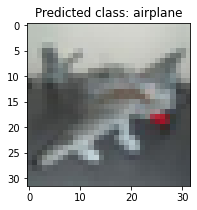

In [37]:
# Expand out the "batch" dimension, and send to the model:
result = predictor.predict(np.expand_dims(img, axis=0))['predictions'][0]
print(f"Result confidences: {result} and the related argmax: {np.argmax(result)}")

# Plot the result:
plt.figure(figsize=(3, 3))
fig = plt.subplot(1, 1, 1)
ax = plt.imshow(np.squeeze(img), cmap="gray")
fig.set_title(f"Predicted class: {labels[np.argmax(result)]}")
plt.show()


In [32]:
result['predictions'][0], np.argmax(result)

([0.00590526732,
  0.0298038349,
  0.000200674927,
  3.53738e-05,
  2.39466317e-06,
  4.75819797e-06,
  4.54125038e-05,
  7.60795911e-06,
  0.0104717789,
  0.953522861],
 0)

## Further Improvements

If you've got the basic train/deploy/call cycle working, congratulations! This core pattern of experimenting in the notebook but executing jobs on scalable hardware is at the heart of the SageMaker data science workflow.

There are still plenty of ways we can use the tools better though: Read on for the next challenges!


### 1. Cut training costs easily with SageMaker Managed Spot Mode

AWS Spot Instances let you take advantage of unused capacity in the AWS cloud, at up to a 90% discount versus standard on-demand pricing! For small jobs like this, taking advantage of this discount is as easy as adding a couple of parameters to the Estimator constructor:

https://sagemaker.readthedocs.io/en/stable/estimators.html

Note that in general, spot capacity is offered at a discounted rate because it's interruptible based on instantaneous demand... Longer-running training jobs should implement checkpoint saving and loading, so that they can efficiently resume if interrupted part way through. More information can be found on the [Managed Spot Training in Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html) page of the [SageMaker Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/).


### 2. Parameterize your algorithm

Being able to change the parameters of your algorithm at run-time (without modifying the `main.py` script each time) is helpful for making your code more re-usable... But even more so because it's a pre-requisite for automatic hyperparameter tuning!

Job parameter parsing should ideally be factored into a separate function, and as a best practice should accept setting values through **both** command line flags (as demonstrated in the [official MXNet MNIST example](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/mxnet_mnist/mnist.py)) **and** the [SageMaker Hyperparameter environment variable(s)](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-container-environmental-variables-user-scripts.html). Perhaps the official MXNet example could be improved by setting environment-variable-driven defaults to the algorithm hyperparameters, the same as it already does for channels?

Refactor your job to accept **epochs** and **batch size** as optional parameters, and show how you can set these before each training run through the [Estimator API](https://sagemaker.readthedocs.io/en/stable/estimators.html).


### 3. Tune your network hyperparameters

Re-use the same approach as before to parameterize some features in the structure of your network: Perhaps the sizes of the `Conv2D` kernels? The number, type, node count, or activation function of layers in the network? No need to stray too far away from the sample architecture!

Instead of manually (or programmatically) calling `estimator.fit()` with different hyperparameters each time, we can use SageMaker's Bayesian Hyperparameter Tuning functionality to explore the space more efficiently!

The SageMaker SDK Docs give a great [overview](https://sagemaker.readthedocs.io/en/stable/overview.html#sagemaker-automatic-model-tuning) of using the HyperparameterTuner, which you can refer to if you get stuck.

First, we'll need to define a specific **metric** to optimize for, which is really a specification of how to scrape metric values from the algorithm's console logs. 

Next, use the [\*Parameter](https://sagemaker.readthedocs.io/en/stable/tuner.html) classes (`ContinuousParameter`, `IntegerParameter` and `CategoricalParameter`) to define appropriate ranges for the hyperparameters whose combination you want to optimize.

With the original estimator, target metric and parameter ranges defined, you'll be able to create a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/tuner.html) and use that to start a hyperparameter tuning job instead of a single model training job.

Pay attention to likely run time and resource consumption when selecting the maximum total number of training jobs and maximum parallel jobs of your hyperparameter tuning run... You can always view and cancel ongoing hyperparameter tuning jobs through the SageMaker Console.


### Additional Challenges

If you have time, the following challenges are trickier, and might stretch your SageMaker knowledge even further!

**Batch Transform / Additional Inference Formats**: As discussed in this notebook, the deployed endpoint expects a particular tensor data format for requests... This complicates the usually-simple task of re-purposing the same model for batch inference (since our data in S3 is in JPEG format). The SageMaker TensorFlow SDK docs provide guidance on accepting custom formats in the ["Create Python Scripts for Custom Input and Output Formats"](https://sagemaker.readthedocs.io/en/stable/using_tf.html#create-python-scripts-for-custom-input-and-output-formats) section. If you can refactor your algorithm to accept JPEG requests when deployed as a real-time endpoint, you'll be able to run it as a batch [Transformer](https://sagemaker.readthedocs.io/en/stable/transformer.html) against images in S3 with a simple `estimator.transformer()` call.

**Optimized Training Formats**: A dataset like this (containing many tiny objects) may take much less time to load in to the algorithm if we either converted it to the standard Numpy format that Keras distributes it in (just 4 files X_train, Y_train, X_test, Y_test); or *streaming* the data with [SageMaker Pipe Mode](https://aws.amazon.com/blogs/machine-learning/using-pipe-input-mode-for-amazon-sagemaker-algorithms/), instead of downloading it up-front.

**Experiment Tracking**: The [SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) feature gives a more structured way to track trials across multiple related experiments (for example, different HPO runs, or between HPO and regular model training jobs). You can use the [official SageMaker Experiments Example](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker-experiments) for guidance on how to track the experiments in this notebook... and should note that the [SageMaker Experiments SDK Docs](https://sagemaker-experiments.readthedocs.io/en/latest/) are maintained separately, since it's a different Python module.


## Clean-Up

Remember to clean up any persistent resources that aren't needed anymore to save costs: The most significant of these are real-time prediction endpoints, and this SageMaker Notebook Instance.

The SageMaker SDK [Predictor](https://sagemaker.readthedocs.io/en/stable/predictors.html) class provides an interface to clean up real-time prediction endpoints; and SageMaker Notebook Instances can be stopped through the SageMaker Console when you're finished.

You might also like to clean up any S3 buckets / content we created, to prevent ongoing storage costs.


In [38]:
predictor.delete_endpoint(delete_endpoint_config=True)